In [1]:
import sys
from pathlib import Path

cwd = Path.cwd().resolve().parent
sys.path.append(str(cwd))


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import optimize

import utils as u
from visualization import papermode
from visualization import can_viz as canv

papermode(plt, size=18)


In [3]:
abbr = "P11"
filename = u.get_filename(abbr)
basename = u.get_basename(filename)
rundir = u.get_rundir(basename)

datadir = cwd / rundir
elec_data_path = datadir / "elec"
odom_data_path = datadir / "odom"
can_path = u.find_canlog(datadir)

figdir = cwd / "figs" / "thesis" / "experimental-setup"


In [4]:
can_df = u.read_canlog(can_path)
canL_df = can_df[can_df.frameID == '501'].copy()
canR_df = can_df[can_df.frameID == '502'].copy()

canL_df["packet"] = canL_df.can_packet.str[4:]
canR_df["packet"] = canR_df.can_packet.str[4:]

u.decompose_packet(canL_df, "packet")
u.decompose_packet(canR_df, "packet")

canL_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canL.csv", index=False)
canR_df.to_csv(cwd / rundir / "elec" / f"{basename}_elec_canR.csv", index=False)

In [5]:
mcu_path = elec_data_path / f"{basename}_elec_mcu_status.csv"
VL_path = elec_data_path / f"{basename}_elec_left_drive_status_battery_voltage.csv"
VR_path = elec_data_path / f"{basename}_elec_right_drive_status_battery_voltage.csv"

VL_df = pd.read_csv(VL_path)
VR_df = pd.read_csv(VR_path)
mcu_df = pd.read_csv(mcu_path)
mcu_df = mcu_df[["time","/mcu/status/measured_battery"]].copy()

In [6]:
VL_df = VL_df.rename(columns={"/left_drive/status/battery_voltage": "VL"})
VR_df = VR_df.rename(columns={"/right_drive/status/battery_voltage": "VR"})
mcu_df = mcu_df.rename(columns={"/mcu/status/current_battery": "VBatt"})


In [7]:
time_min = min(VL_df.time.min(), VR_df.time.min())
time_max = max(VL_df.time.max(), VR_df.time.max())
reltime_max = time_max - time_min


In [8]:
VL_df["time_rel"] = VL_df.time - time_min
VR_df["time_rel"] = VR_df.time - time_min
canL_df["time_rel"] = canL_df.time - time_min
canR_df["time_rel"] = canR_df.time - time_min
mcu_df["time_rel"] = mcu_df.time - time_min


In [9]:
canL_mask = (canL_df.time_rel > 0) & (canL_df.time < time_max)
canL_df = canL_df[canL_mask].copy()

canR_mask = (canR_df.time_rel > 0) & (canR_df.time < time_max)
canR_df = canR_df[canR_mask].copy()

mcu_mask = (mcu_df.time_rel > 0) & (mcu_df.time < time_max)
mcu_df = mcu_df[mcu_mask].copy()

Text(0.5, 0.01, 'Time (s)')

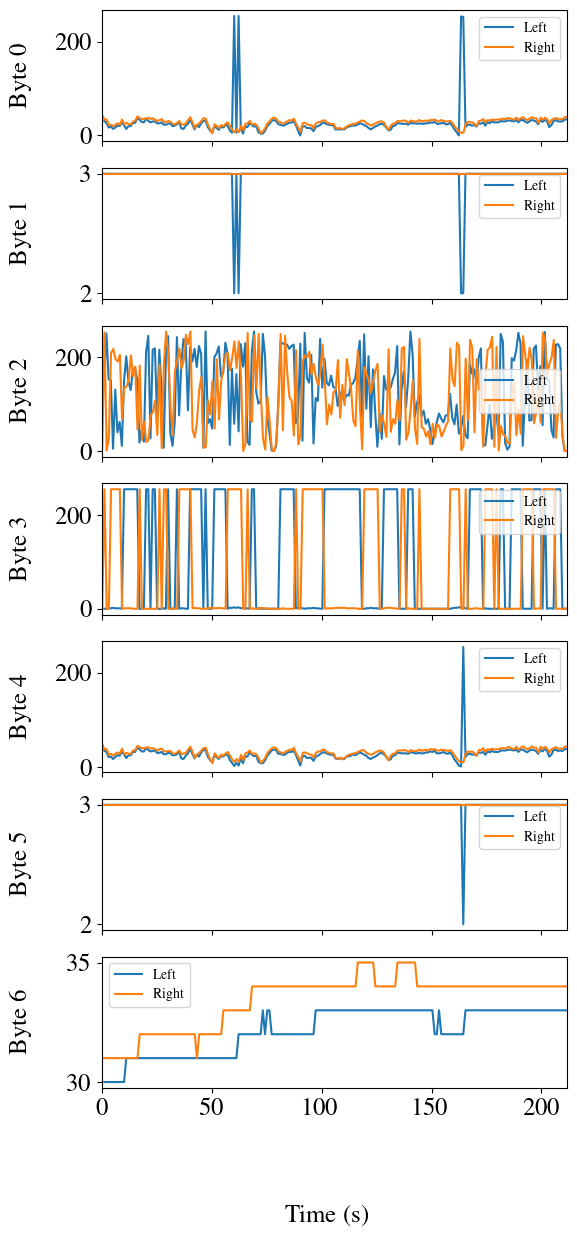

In [10]:
fig, subfigs = plt.subplots(nrows=7, sharex=True, figsize=(6,14))
for idx, ax in enumerate(subfigs.reshape(-1)):
    ax.plot(canL_df.time_rel, canL_df[f"b{idx}"], label="Left")
    ax.plot(canR_df.time_rel, canR_df[f"b{idx}"], label="Right")
    ax.set_ylabel(f"Byte ${{{idx}}}$")
    ax.legend(fontsize=10)
    ax.yaxis.set_label_coords(-0.15, 0.5)

ax.set_xlim((0, reltime_max))

fig.supxlabel("Time (s)", fontsize=18)

In [11]:
can_df = u.read_canlog(can_path)
frameIDs = can_df.frameID.unique()
can_dfs = {fID: can_df[can_df.frameID == fID].copy() for fID in frameIDs}

for fID in frameIDs:
    frame_df = can_dfs[fID]
    frame_df["packet"] = frame_df.can_packet.str[4:]
    packet_len = frame_df.packet.str.len().unique()[0]
    u.decompose_packet(frame_df, "packet", n_bytes=packet_len//2)
    frame_df["time_rel"] = frame_df.time - time_min
    frame_mask = (frame_df.time_rel > 0) & (frame_df.time < time_max)
    frame_df = frame_df[frame_mask].copy()
    can_dfs[fID] = {"csv": frame_df, "len":packet_len//2}


In [12]:
print([f for f in sorted(can_dfs.keys())])


['000', '080', '181', '182', '201', '202', '281', '282', '381', '382', '401', '402', '481', '482', '501', '502', '701', '702', '740']


In [13]:
canL_df.head()

time busID          can_packet frameID          packet  b0  \
470036  1.662066e+09  can0  501#1F039B0023031E     501  1F039B0023031E  31   
470314  1.662066e+09  can0  501#1B03FB0020031E     501  1B03FB0020031E  27   
470592  1.662066e+09  can0  501#1103990115031E     501  1103990115031E  17   
470870  1.662066e+09  can0  501#1303970116031E     501  1303970116031E  19   
471148  1.662066e+09  can0  501#0E03050211031E     501  0E03050211031E  14   

        b1   b2  b3  b4  b5  b6  time_rel  
470036   3  155   0  35   3  30  0.999854  
470314   3  251   0  32   3  30  2.000043  
470592   3  153   1  21   3  30  3.009751  
470870   3  151   1  22   3  30  4.009745  
471148   3    5   2  17   3  30  5.009890

In [16]:
canL_df.packet.apply(bytes.fromhex)

470036       b'\x1f\x03\x9b\x00#\x03\x1e'
470314       b'\x1b\x03\xfb\x00 \x03\x1e'
470592    b'\x11\x03\x99\x01\x15\x03\x1e'
470870    b'\x13\x03\x97\x01\x16\x03\x1e'
471148    b'\x0e\x03\x05\x02\x11\x03\x1e'
                       ...               
527264          b'\x1e\x03\xe4\xff"\x03!'
527542          b'\x1e\x03\xdb\xff#\x03!'
527820             b'\x1e\x03 \x00"\x03!'
528078             b'"\x03\x00\x00&\x03!'
528336             b'"\x03\x00\x00&\x03!'
Name: packet, Length: 211, dtype: object

Text(0.5, 0.01, 'Time (s)')

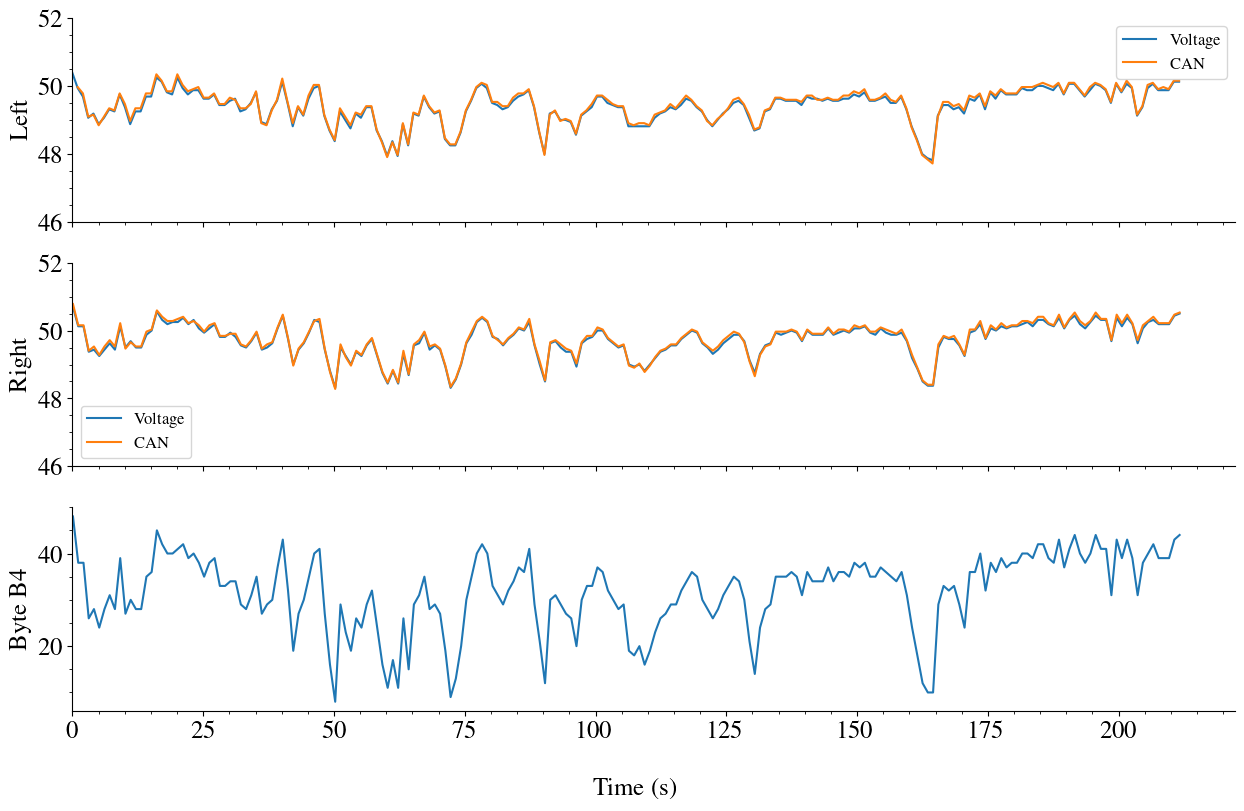

In [28]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, sharex=True, figsize=(15, 9))

packet_len = len(canL_df.columns) - 6
byte_columns = [f"b{i}" for i in range(packet_len)]
byte_arrL = canL_df[byte_columns].copy().to_numpy()
byte_arrR = canR_df[byte_columns].copy().to_numpy()
# byte_arrL = np.hstack([byte_arrL, np.ones((byte_arrL.shape[0], 1))])
# byte_arrR = np.hstack([byte_arrR, np.ones((byte_arrR.shape[0], 1))])
# coeffs = np.array([0, 1/256, 1/16, 16, 0, 0, 0])
coeffs = np.array([0, 0, 0, 0, 1/16, 16, 0])
canL_value = byte_arrL @ coeffs
canR_value = byte_arrR @ coeffs

offset=-0.22

ax1.plot(VL_df.time_rel, VL_df.VL, label="Voltage")
ax2.plot(VR_df.time_rel, VR_df.VR, label="Voltage")
ax1.plot(canL_df.time_rel, canL_value + offset, label="CAN")
ax2.plot(canR_df.time_rel, canR_value + offset, label="CAN")
ax3.plot(canR_df.time_rel, canR_df.b4, label="CAN")

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
ax1.set_ylabel("Left")
ax2.set_ylabel("Right")
ax3.set_ylabel("Byte B4")
ax1.spines[["right", "top"]].set_visible(False)
ax2.spines[["right", "top"]].set_visible(False)
ax3.spines[["right", "top"]].set_visible(False)
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax1.set_ylim(bottom=46, top=52)
ax2.set_ylim(bottom=46, top=52)

ax2.set_xlim(left=0)

fig.supxlabel("Time (s)", fontsize=18)
